In [45]:
from numba import cuda,float32
import numpy as np
from PIL import Image
from matplotlib import pyplot
import math
import os
%env  NUMBA_ENABLE_CUDASIM = 1

env: NUMBA_ENABLE_CUDASIM=1


In [46]:
gaussian_blur = np.array([[1,2,1],[2,4,2],[1,2,1]])/16 
threadsperblock = (16, 16)

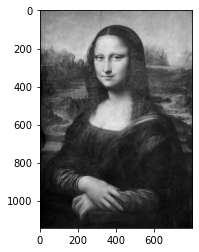

In [47]:
image = Image.open('../images/ml_gray.jpg')
pyplot.imshow(image,cmap = pyplot.cm.gray)
input_image = np.array(image)[:,:,0]

In [48]:
def get_dim(image):
    blockspergrid_x = math.ceil(image.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(image.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    return blockspergrid,threadsperblock

Too many memory accesses to the global memory. Can be further optimized by using the shared memory for local accesses within each SM. Using 

In [49]:
@cuda.jit
def gaussian_blur_kernel(d_input,d_output):
    mask = cuda.const.array_like(gaussian_blur)
    i,j = cuda.grid(2)
    rows,columns =d_input.shape
    if i >= rows or j >= columns:
        return
    delta_i = mask.shape[0]//2
    delta_j = mask.shape[0]//2
    res = 0
    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            i_k = i - k + delta_i
            j_l = j - l + delta_j
            if (i_k >= 0) and (i_k < rows) and (j_l >= 0) and (j_l < columns):  
                res += mask[k, l] * d_input[i_k, j_l]
    d_output[i, j] = res

In [50]:
@cuda.jit
def fast_gaussian_blur_kernel(d_input,d_output):
    mask = cuda.const.array_like(gaussian_blur)
    shared_array = cuda.shared.array(shape=threadsperblock, dtype=float32)
    x,y = cuda.grid(2)
    local_x = cuda.threadIdx.x
    local_y = cuda.threadIdx.y
    rows,columns =d_input.shape
    shared_array[local_x,local_y] = d_input[x,y]
    cuda.syncthreads()
    tile_start_x = cuda.blockDim.x * cuda.blockIdx.x
    tile_start_y = cuda.blockDim.y * cuda.blockIdx.y
    tile_end_x = tile_start_x + threadsperblock[0]
    tile_end_y = tile_start_y + threadsperblock[0]
    delta_i = mask.shape[0]//2
    delta_j = mask.shape[0]//2   
    mask_start_x = x - delta_i
    mask_start_y = y - delta_j
    res = 0
    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            x_index = mask_start_x + k 
            y_index = mask_start_y + l
            if x_index >= 0 and x_index < rows and y_index >=0 and y_index < columns:
                if x_index >= tile_start_x and x_index < tile_end_x and y_index >= tile_end_y and y_index < tile_end_y:
                    res += mask[k,l] * shared_array[local_x +k - delta_i ,local_x +k - delta_i]
                else:
                    res += mask[k,l] * d_input[x_index,y_index]
    d_output[x,y] = res
    return

    
            # calulating the element to read from the shared array

        



In [52]:
d_input = cuda.to_device(np.ascontiguousarray(input_image))
d_output = cuda.device_array(input_image.shape)
kernel = cuda.to_device(gaussian_blur)
blockspergrid,threadsperblock = get_dim(input_image)
gaussian_blur_kernel[blockspergrid,threadsperblock] (d_input,d_output)
output = d_output.copy_to_host()
pyplot.imshow(Image.fromarray(output))


CudaAPIError: [700] Call to cuMemAlloc results in UNKNOWN_CUDA_ERROR

In [ ]:
Image.fromarray(output).convert("L").save("../images/Tree_gb.jpeg")